In [2]:
import pandas as pd
import os
from tqdm import tqdm_notebook, tnrange
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

import scipy
from scipy.optimize import minimize
from scipy.sparse import csr_matrix, vstack, hstack

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import cvxpy as cp


module_path = os.path.abspath(os.path.join('..'))

%matplotlib inline

In [3]:
protein_df_PD1_test = pd.read_csv(module_path+'/data/harel/protein_df_PD1_test_feats.csv', index_col=0)

In [4]:
len(protein_df_PD1_test.T.columns)

15

In [5]:
proteins_df = pd.read_csv(module_path+'/data/harel/protein_df_PD1.csv', index_col=0)
protein_list = list(set(list(proteins_df["Gene_Names"])))
interactome_protein_set = set(np.loadtxt(module_path+
                            '/data/interactome/proteins_in_interactome.txt',
                            dtype=str))

In [6]:
intersection_proteins_to_keep = set()
semicolon_matches = ()
num_nan = 0
for protein in tqdm_notebook(protein_list):
    if protein in interactome_protein_set:
        intersection_proteins_to_keep.add(protein)
    elif len(protein.split(";")) > 1:
        
        if np.sum([x in interactome_protein_set for x in protein.split(";")]) > 1:
            print(protein.split(";"))

In [7]:
g = nx.read_edgelist(module_path+"/data/interactome/inbiomap_reduced.txt", 
                     data=(('confidence',float),))

In [8]:
intersection_proteins = set(g.nodes())
proteins_not_found = set(protein_list) - intersection_proteins
num_intersection_proteins = len(intersection_proteins)
num_orphan_proteins = len(proteins_not_found)

In [9]:
proteins_df["In_Interactome"] = list(proteins_df["Gene_Names"].isin(list(intersection_proteins)))
protein_new = proteins_df.sort_values(by="In_Interactome", ascending=False).reset_index(drop=True)

In [10]:
protein_number_to_names = list(protein_new["Gene_Names"])
protein_names_to_number = {}

for ind, protein in enumerate(protein_number_to_names):
    protein_names_to_number[protein] = ind

In [11]:
train_cols = [x for x in protein_new.columns if x not in protein_df_PD1_test.T.columns]

In [12]:
protein_test = protein_new[list(protein_df_PD1_test.T.columns) + ["Gene_Names", "In_Interactome"]]
protein_train = protein_new[train_cols]

A = protein_train.to_numpy()[:,:-2].T
Atest = protein_test.to_numpy()[:,:-2].T
Afull = protein_new.to_numpy()[:,:-2].T

In [13]:
A.shape, Atest.shape, Afull.shape

((59, 4249), (15, 4249), (74, 4249))

In [14]:
response_df = pd.read_csv(module_path+'/data/harel/response_df.csv', index_col=0)

In [15]:
patient_order_train = protein_train.columns[:-2]
y_raw_train = []

for patient in tqdm_notebook(patient_order_train):
    try:
        pfs = float(response_df[response_df["Sample ID"]==patient]["PFS time (months)"])
    except:
        new_patient = " ".join(patient.split("_"))
        try:
            pfs = float(response_df[response_df["Sample ID"]==new_patient]["PFS time (months)"])
        except:
            print(patient, new_patient)
            raise
        
    y_raw_train.append(pfs)
yraw_train = np.array(y_raw_train).reshape(-1,1)
scaler = StandardScaler()
scaler.fit(yraw_train)
y = scaler.transform(yraw_train.reshape(-1, 1)).reshape(-1)

In [16]:
patient_order_test = protein_test.columns[:-2]
y_raw_test = []

for patient in tqdm_notebook(patient_order_test):
    try:
        pfs = float(response_df[response_df["Sample ID"]==patient]["PFS time (months)"])
    except:
        new_patient = " ".join(patient.split("_"))
        try:
            pfs = float(response_df[response_df["Sample ID"]==new_patient]["PFS time (months)"])
        except:
            print(patient, new_patient)
            raise
        
    y_raw_test.append(pfs)
yraw_test = np.array(y_raw_test).reshape(-1,1)
scaler = StandardScaler()
scaler.fit(yraw_test)
y_test = scaler.transform(yraw_test.reshape(-1, 1)).reshape(-1)

In [17]:
patient_order = protein_new.columns[:-2]
y_raw_full = []

for patient in tqdm_notebook(patient_order):
    try:
        pfs = float(response_df[response_df["Sample ID"]==patient]["PFS time (months)"])
    except:
        new_patient = " ".join(patient.split("_"))
        try:
            pfs = float(response_df[response_df["Sample ID"]==new_patient]["PFS time (months)"])
        except:
            print(patient, new_patient)
            raise
        
    y_raw_full.append(pfs)
yraw_full = np.array(y_raw_full).reshape(-1,1)
scaler = StandardScaler()
scaler.fit(yraw_full)
y_full = scaler.transform(yraw_full.reshape(-1, 1)).reshape(-1)

In [18]:
nodlist = protein_train["Gene_Names"][:num_intersection_proteins]

L = nx.normalized_laplacian_matrix(g,nodelist=nodlist, weight="confidence")
U = nx.incidence_matrix(g,nodelist=nodlist, oriented=True, weight="confidence")

print(L.shape, U.shape)

Reg0 = np.eye(num_orphan_proteins+num_intersection_proteins)
Reg1 = csr_matrix(scipy.linalg.block_diag(
    L.todense(),np.eye(num_orphan_proteins)))
temp1 = hstack([U.T, csr_matrix(np.zeros((U.shape[1],num_orphan_proteins)))])
Reg2 = vstack ([temp1, csr_matrix(np.eye(num_intersection_proteins+num_orphan_proteins))])
Reg3 = csr_matrix(scipy.linalg.block_diag(
    L.todense(),np.zeros((num_orphan_proteins,num_orphan_proteins))))

(3995, 3995) (3995, 165392)


In [19]:
def plot_regularization_path(lambd_values, beta_values):
    num_coeffs = len(beta_values[0])
    for i in range(num_coeffs):
        plt.plot(lambd_values, [wi[i] for wi in beta_values])
    plt.xlabel(r"$\alpha$", fontsize=16)
    plt.xscale("log")
    plt.title("Regularization Path")
    plt.grid()
    plt.show()

# Vanilla lasso baseline

In [22]:
x = cp.Variable(num_intersection_proteins+num_orphan_proteins)
alph = cp.Parameter(nonneg=True)
objective = cp.Minimize((1. / (2*A.shape[0])) * cp.sum_squares(A*x - y)+ alph* cp.norm1(Reg0*x))
prob = cp.Problem(objective)
vanilla_lassos = []
vanilla_lasso_train_err = []
vanilla_lasso_test_err = []


threshold = 0.01
alpha_values =  np.logspace(-1, 0, 10)

for v in tqdm_notebook(alpha_values):
    alph.value = v
    prob.solve()
    vanilla_lassos.append(x.value)
    
    cols_to_keep = np.where(np.abs(x.value) > threshold)[0]
    if not cols_to_keep.size:
        train_err = mean_squared_error(y, np.mean(y)*np.ones(y.shape))
        test_err = mean_squared_error(y_test, np.mean(y_test)*np.ones(y_test.shape))
    else:
        A_new = A[:, cols_to_keep]
        Atest_new = Atest[:, cols_to_keep]
        regr = linear_model.LinearRegression()
        regr.fit(A_new, y)
        y_pred_train = regr.predict(A_new)
        y_pred_test = regr.predict(Atest_new)
        train_err = mean_squared_error(y, y_pred_train)
        test_err = mean_squared_error(y_test, y_pred_test)
    
    vanilla_lasso_train_err.append(train_err)
    vanilla_lasso_test_err.append(test_err)

In [95]:
vanilla_lasso_train_err = []
vanilla_lasso_test_err = []

threshold = 0.001
num_features = 10
for star_lasso in tqdm_notebook(vanilla_lassos):
    
    top_cols = np.argsort(-abs(star_lasso))[:num_features]
    cols_to_keep = [x for x in top_cols if np.abs(star_lasso[x])> threshold]
    
    if not cols_to_keep:
        train_err = mean_squared_error(y, np.mean(y)*np.ones(y.shape))
        test_err = mean_squared_error(y_test, np.mean(y_test)*np.ones(y_test.shape))
    else:
        A_new = A[:, cols_to_keep]
        Atest_new = Atest[:, cols_to_keep]
        regr = linear_model.LinearRegression()
        regr.fit(A_new, y)
        y_pred_train = regr.predict(A_new)
        y_pred_test = regr.predict(Atest_new)
        train_err = mean_squared_error(y, y_pred_train)
        test_err = mean_squared_error(y_test, y_pred_test)
    
    vanilla_lasso_train_err.append(train_err)
    vanilla_lasso_test_err.append(test_err)

Text(0.5, 0, '$\\alpha$')

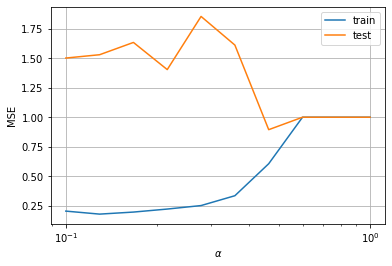

In [114]:
plt.plot(alpha_values, vanilla_lasso_train_err, label="train")
plt.plot(alpha_values, vanilla_lasso_test_err, label="test")
plt.legend()
plt.grid()
plt.xscale('log')
plt.ylabel("MSE")
plt.xlabel(r"$\alpha$")

# Laplacian Lasso

In [99]:
x = cp.Variable(num_intersection_proteins+num_orphan_proteins)
alph = cp.Parameter(nonneg=True)
objective = cp.Minimize((1. / (2*A.shape[0])) * cp.sum_squares(A*x - y)+ alph* cp.norm1(Reg1*x))
prob = cp.Problem(objective)
laplacian_lassos = []
laplacian_lasso_train_err = []
laplacian_lasso_test_err = []

threshold = 0.01
alpha_values =  np.logspace(-1, 0, 10)

for v in tqdm_notebook(alpha_values):
    alph.value = v
#     print(v)
    prob.solve()
    laplacian_lassos.append(x.value)
    
    cols_to_keep = np.where(np.abs(x.value) > threshold)[0]
    if not cols_to_keep.size:
        train_err = mean_squared_error(y, np.mean(y)*np.ones(y.shape))
        test_err = mean_squared_error(y_test, np.mean(y_test)*np.ones(y_test.shape))
    else:
        A_new = A[:, cols_to_keep]
        Atest_new = Atest[:, cols_to_keep]
        regr = linear_model.LinearRegression()
        regr.fit(A_new, y)
        y_pred_train = regr.predict(A_new)
        y_pred_test = regr.predict(Atest_new)
        train_err = mean_squared_error(y, y_pred_train)
        test_err = mean_squared_error(y_test, y_pred_test)
    
    laplacian_lasso_train_err.append(train_err)
    laplacian_lasso_test_err.append(test_err)

0.1
0.1291549665014884
0.16681005372000587
0.21544346900318834
0.2782559402207124
0.35938136638046275
0.46415888336127786
0.5994842503189409
0.774263682681127
1.0



In [110]:
laplacian_lasso_train_err = []
laplacian_lasso_test_err = []

threshold = 0.001
num_features = 10
cols_kept_laplacian = []
for laplacian_lasso in tqdm_notebook(laplacian_lassos):
    
    top_cols = np.argsort(-abs(laplacian_lasso))[:num_features]
    cols_to_keep = [x for x in top_cols if np.abs(laplacian_lasso[x])> threshold]
    cols_kept_laplacian.append(cols_to_keep)
    if not cols_to_keep:
        train_err = mean_squared_error(y, np.mean(y)*np.ones(y.shape))
        test_err = mean_squared_error(y_test, np.mean(y_test)*np.ones(y_test.shape))
    else:
        A_new = A[:, cols_to_keep]
        Atest_new = Atest[:, cols_to_keep]
        regr = linear_model.LinearRegression()
        regr.fit(A_new, y)
        y_pred_train = regr.predict(A_new)
        y_pred_test = regr.predict(Atest_new)
        train_err = mean_squared_error(y, y_pred_train)
        test_err = mean_squared_error(y_test, y_pred_test)
    
    laplacian_lasso_train_err.append(train_err)
    laplacian_lasso_test_err.append(test_err)

Text(0.5, 0, '$\\alpha$')

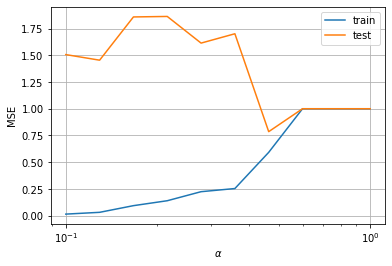

In [100]:
plt.plot(alpha_values, laplacian_lasso_train_err, label="train")
plt.plot(alpha_values, laplacian_lasso_test_err, label="test")
plt.legend()
plt.grid()
plt.xscale('log')
plt.ylabel("MSE")
plt.xlabel(r"$\alpha$")

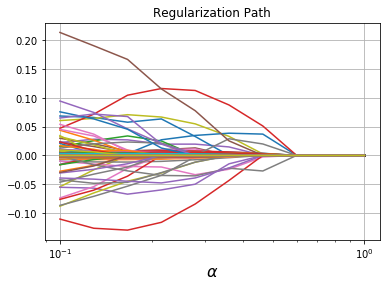

In [101]:
plot_regularization_path(alpha_values, laplacian_lassos)

[('S100B', 20), ('S100A1', 19), ('CBS', 351), ('COX6B1', 48), ('S100A4', 28), ('SPG21', 15), ('S100A11', 16), ('CACYBP', 54), ('S100A6', 19), ('UCHL3', 55)]
['S100B', 'S100A1', 'CBS', 'COX6B1', 'S100A4', 'SPG21', 'S100A11', 'CACYBP', 'S100A6', 'UCHL3']


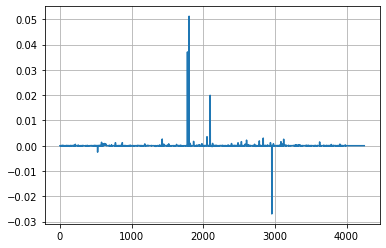

In [113]:
plt.plot(laplacian_lassos[6])
plt.grid()
print(g.degree(protein_number_to_names[z] for z in cols_kept_laplacian[6]))
print([protein_number_to_names[z] for z in cols_kept_laplacian[6]])

# Laplacian Elastic Net

In [125]:
lambda_values = np.logspace(-2, 0, 10)
alpha_values = [0.1, 0.5, 0.9]
hyperparameters_laplacian_elnet = np.zeros((len(lambda_values), 
                    len(alpha_values),
                    num_intersection_proteins+num_orphan_proteins))

lambd1 = cp.Parameter(nonneg=True)
lambd2 = cp.Parameter(nonneg=True)
x = cp.Variable(num_intersection_proteins+num_orphan_proteins)
objective = cp.Minimize((1. / (2*A.shape[0])) * cp.sum_squares(A*x - y)+ 
                        lambd1* cp.sum_squares(Reg3*x) +
                       lambd2*cp.norm1(x))
prob = cp.Problem(objective)

for ind1, v in tqdm_notebook(enumerate(lambda_values)):
    for ind2, u in tqdm_notebook(enumerate(alpha_values)):
        lambd1.value = v*u
        lambd2.value = (1-v)*u
        prob.solve()
        hyperparameters_laplacian_elnet[ind1,ind2,:] = x.value

In [154]:
laplacian_elnet_train_err = np.zeros((len(lambda_values),len(alpha_values)))
laplacian_elnet_test_err = np.zeros((len(lambda_values), 
                    len(alpha_values)))
                                    
cols_kept_laplacian_elnet = [[[]for x in alpha_values] for y in lambda_values]

threshold = 0.001
num_features = 10

for ind1, v in tqdm_notebook(enumerate(lambda_values)):
    for ind2, u in enumerate(alpha_values):
        laplacian_elnet = hyperparameters_laplacian_elnet[ind1][ind2][:]
            
        top_cols = np.argsort(-abs(laplacian_elnet))[:num_features]
        cols_to_keep = [x for x in top_cols if np.abs(laplacian_elnet[x])> threshold]
        cols_kept_laplacian_elnet[ind1][ind2] = cols_to_keep
                                    
        if not cols_to_keep:
            train_err = mean_squared_error(y, np.mean(y)*np.ones(y.shape))
            test_err = mean_squared_error(y_test, np.mean(y_test)*np.ones(y_test.shape))
        else:
            A_new = A[:, cols_to_keep]
            Atest_new = Atest[:, cols_to_keep]
            regr = linear_model.LinearRegression()
            regr.fit(A_new, y)
            y_pred_train = regr.predict(A_new)
            y_pred_test = regr.predict(Atest_new)
            train_err = mean_squared_error(y, y_pred_train)
            test_err = mean_squared_error(y_test, y_pred_test)
    
        laplacian_elnet_train_err[ind1][ind2] = train_err
        laplacian_elnet_test_err[ind1][ind2] = test_err

In [156]:
print("Train errors")
print(laplacian_elnet_train_err)
print("Test errors")
print(laplacian_elnet_test_err)

Train errors
[[0.20376602 0.6667349  1.        ]
 [0.20376602 0.6667349  1.        ]
 [0.20376602 0.6667349  1.        ]
 [0.20376602 0.6667349  1.        ]
 [0.20376602 0.5963654  1.        ]
 [0.20376602 0.50524708 1.        ]
 [0.18864505 0.40567325 1.        ]
 [0.18864505 0.31480406 1.        ]
 [0.22681757 0.23231955 0.33953842]
 [0.48633974 0.48633974 0.48633974]]
Test errors
[[1.50180447 0.80374904 1.        ]
 [1.50180447 0.80374904 1.        ]
 [1.50180447 0.80374904 1.        ]
 [1.50180447 0.80374904 1.        ]
 [1.50180447 0.88428971 1.        ]
 [1.50180447 1.04018842 1.        ]
 [1.48323445 1.29057712 1.        ]
 [1.48323445 1.64143047 1.        ]
 [1.39431618 1.45857606 1.44515267]
 [1.35836633 1.35836633 1.35836633]]


[('S100A1', 19), ('MTPN', 13)]
['S100A1', 'MTPN']


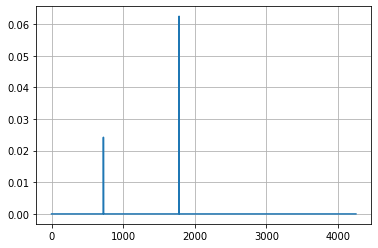

In [158]:
plt.plot(hyperparameters_laplacian_elnet[2][1])
plt.grid()
print(g.degree(protein_number_to_names[z] for z in cols_kept_laplacian_elnet[2][1]))
print([protein_number_to_names[z] for z in cols_kept_laplacian_elnet[2][1]])

# Incidence Lasso

In [20]:
for ed in g.edges():
    norm_conf = g.edges[ed]["confidence"]*(1./ g.degree(ed[0], "confidence") + 1./ g.degree(ed[0], "confidence"))
    g.edges[ed].update(norm_conf=norm_conf)
    
U1 = nx.incidence_matrix(g,nodelist=nodlist, oriented=True, weight="norm_conf")
Reg4 = hstack([U1.T, csr_matrix(np.zeros((U1.shape[1],num_orphan_proteins)))])

In [184]:
lambda_values = np.logspace(-2, np.log10(0.6), 10)
alpha_values = [0.1, 0.5, 0.9]
incidence_lassos = np.zeros((len(lambda_values), 
                    len(alpha_values),
                    num_intersection_proteins+num_orphan_proteins))

lambd1 = cp.Parameter(nonneg=True)
lambd2 = cp.Parameter(nonneg=True)
x = cp.Variable(num_intersection_proteins+num_orphan_proteins)
objective = cp.Minimize((1. / (2*A.shape[0])) * cp.sum_squares(A*x - y)+ 
                        lambd1* cp.norm1(Reg4*x) +
                       lambd2*cp.norm1(x))
prob = cp.Problem(objective)

for ind1, v in tqdm_notebook(enumerate(lambda_values)):
    for ind2, u in tqdm_notebook(enumerate(alpha_values)):
        lambd1.value = v*u
        lambd2.value = (1-v)*u
        prob.solve()
        incidence_lassos[ind1,ind2,:] = x.value

In [185]:
incidence_lasso_train_err = np.zeros((len(lambda_values),len(alpha_values)))
incidence_lasso_test_err = np.zeros((len(lambda_values), 
                    len(alpha_values)))
                                    
cols_kept_incidence_lasso = [[[]for x in alpha_values] for y in lambda_values]

threshold = 0.001
num_features = 10

for ind1, v in tqdm_notebook(enumerate(lambda_values)):
    for ind2, u in enumerate(alpha_values):
        incidence_lasso = incidence_lassos[ind1][ind2][:]
            
        top_cols = np.argsort(-abs(incidence_lasso))[:num_features]
        cols_to_keep = [x for x in top_cols if np.abs(incidence_lasso[x])> threshold]
        cols_kept_incidence_lasso[ind1][ind2] = cols_to_keep
                                    
        if not cols_to_keep:
            train_err = mean_squared_error(y, np.mean(y)*np.ones(y.shape))
            test_err = mean_squared_error(y_test, np.mean(y_test)*np.ones(y_test.shape))
        else:
            A_new = A[:, cols_to_keep]
            Atest_new = Atest[:, cols_to_keep]
            regr = linear_model.LinearRegression()
            regr.fit(A_new, y)
            y_pred_train = regr.predict(A_new)
            y_pred_test = regr.predict(Atest_new)
            train_err = mean_squared_error(y, y_pred_train)
            test_err = mean_squared_error(y_test, y_pred_test)
    
        incidence_lasso_train_err[ind1][ind2] = train_err
        incidence_lasso_test_err[ind1][ind2] = test_err

In [186]:
print("Train errors")
print(incidence_lasso_train_err)
print("Test errors")
print(incidence_lasso_test_err)

Train errors
[[0.2165642  0.6667349  1.        ]
 [0.1888002  0.6667349  1.        ]
 [0.1888002  0.6667349  1.        ]
 [0.1888002  0.6667349  1.        ]
 [0.18103653 0.6667349  1.        ]
 [0.15979049 0.6667349  1.        ]
 [0.17913173 0.6667349  1.        ]
 [0.22034334 0.48817261 1.        ]
 [0.23457972 0.48038129 1.        ]
 [0.31957898 0.36951735 0.57073997]]
Test errors
[[1.49750504 0.80374904 1.        ]
 [1.54438079 0.80374904 1.        ]
 [1.54438079 0.80374904 1.        ]
 [1.54438079 0.80374904 1.        ]
 [1.50428633 0.80374904 1.        ]
 [1.39710719 0.80374904 1.        ]
 [1.26704416 0.80374904 1.        ]
 [1.24657188 0.94449972 1.        ]
 [1.35791322 1.2369432  1.        ]
 [1.20836035 1.08848172 0.96228603]]


[('S100A1', 19), ('MTPN', 13)]
['S100A1', 'MTPN']


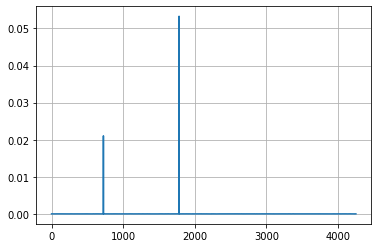

In [187]:
plt.plot(incidence_lassos[0][1])
plt.grid()
print(g.degree(protein_number_to_names[z] for z in cols_kept_incidence_lasso[0][1]))
print([protein_number_to_names[z] for z in cols_kept_incidence_lasso[0][1]])

# Incidence Elnet

In [ ]:
lambda_values = np.logspace(-2, np.log10(0.6), 5)
alpha_values = [0.1, 0.5, 0.9]
incidence_elnets = np.zeros((len(lambda_values), 
                    len(alpha_values),
                    num_intersection_proteins+num_orphan_proteins))

lambda_values = [0.01]
alpha_values = [0.5]

lambd1 = cp.Parameter(nonneg=True)
lambd2 = cp.Parameter(nonneg=True)
x = cp.Variable(num_intersection_proteins+num_orphan_proteins)
objective = cp.Minimize((1. / (2*A.shape[0])) * cp.sum_squares(A*x - y)+ 
                        lambd1* cp.sum_squares(Reg4*x) +
                       lambd2*cp.norm1(x))
prob = cp.Problem(objective)

for ind1, v in tqdm_notebook(enumerate(lambda_values)):
    for ind2, u in tqdm_notebook(enumerate(alpha_values)):
        lambd1.value = v*u
        lambd2.value = (1-v)*u
        prob.solve()
        incidence_elnets[ind1,ind2,:] = x.value

In [ ]:
incidence_elnet_train_err = np.zeros((len(lambda_values),len(alpha_values)))
incidence_elnet_test_err = np.zeros((len(lambda_values), 
                    len(alpha_values)))
                                    
cols_kept_incidence_elnet = [[[]for x in alpha_values] for y in lambda_values]

threshold = 0.001
num_features = 10

for ind1, v in tqdm_notebook(enumerate(lambda_values)):
    for ind2, u in enumerate(alpha_values):
        incidence_elnet = incidence_elnets[ind1][ind2][:]
            
        top_cols = np.argsort(-abs(incidence_elnet))[:num_features]
        cols_to_keep = [x for x in top_cols if np.abs(incidence_elnet[x])> threshold]
        cols_kept_incidence_elnet[ind1][ind2] = cols_to_keep
                                    
        if not cols_to_keep:
            train_err = mean_squared_error(y, np.mean(y)*np.ones(y.shape))
            test_err = mean_squared_error(y_test, np.mean(y_test)*np.ones(y_test.shape))
        else:
            A_new = A[:, cols_to_keep]
            Atest_new = Atest[:, cols_to_keep]
            regr = linear_model.LinearRegression()
            regr.fit(A_new, y)
            y_pred_train = regr.predict(A_new)
            y_pred_test = regr.predict(Atest_new)
            train_err = mean_squared_error(y, y_pred_train)
            test_err = mean_squared_error(y_test, y_pred_test)
    
        incidence_elnet_train_err[ind1][ind2] = train_err
        incidence_elnet_test_err[ind1][ind2] = test_err